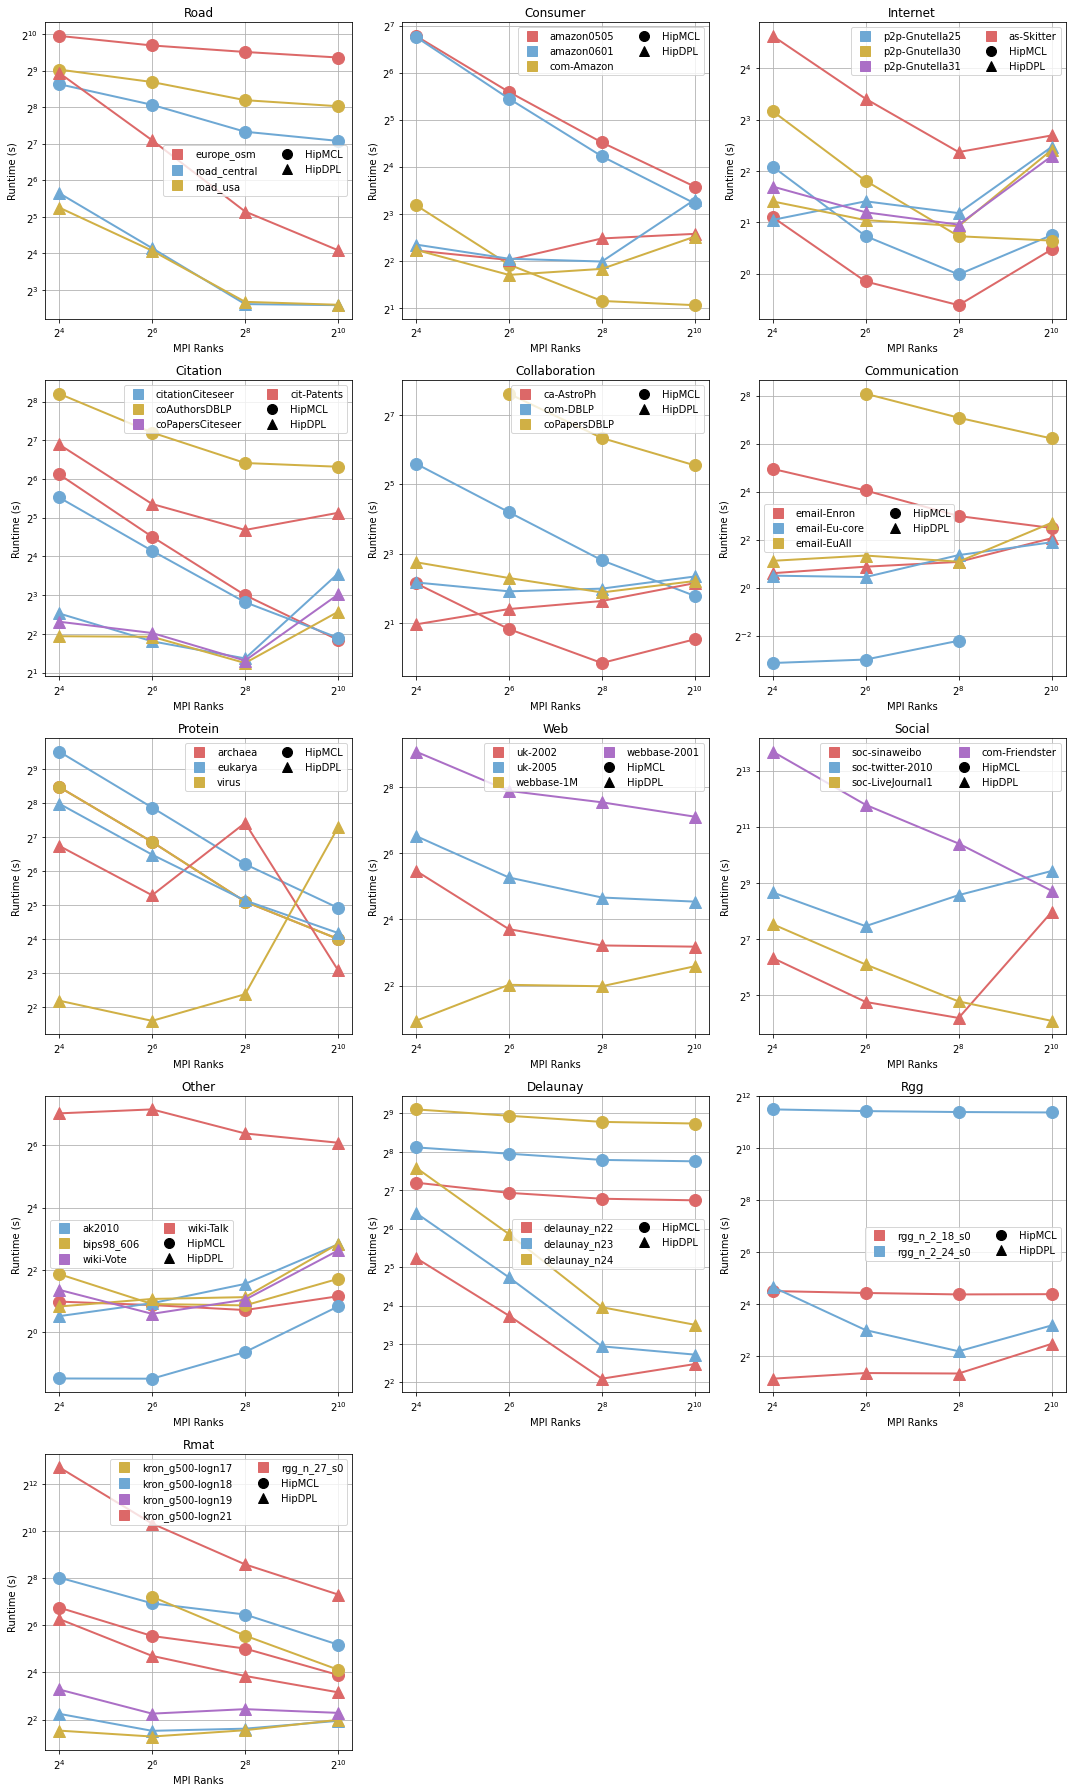

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from matplotlib.lines import Line2D

# Load the primary and secondary CSV files
file_path_1 = '/lustre/orion/gen150/world-shared/abby-summer24/hipmcl/test/graphs/hipmcl_runtimes.csv'  
file_path_2 = '/lustre/orion/gen150/world-shared/abby-summer24/hipmcl/test/graphs/hipdpl_runtimes.csv'

df_1 = pd.read_csv(file_path_1)
df_2 = pd.read_csv(file_path_2)
df_2 = df_2[:-4]  # Remove the last 4 rows

# Define the custom domain order with capitalized first letters
custom_domain_order = ["Road", "Consumer", "Internet", "Citation", "Collaboration", "Communication", 
                       "Protein", "Web", "Social", "Other", "Delaunay", "Rgg", "Rmat"]

# Plotting parameters
n_cols = 3
n_rows = math.ceil(len(custom_domain_order) / n_cols)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axs = axs.flatten()

# Set pastel colors for the lines
pastel_colors = ["#DC6868", "#6EA8D4", "#D0B045", "#AB6FC6"]  # Soft red, blue, mustard yellow, and lavender
markers = ['o', '^']  # Circle for HipMCL, Triangle for HipDPL

# Loop through each domain to plot data from both files
for i, domain in enumerate(custom_domain_order):
    # Check if the domain has data in either CSV file
    domain_data_1 = df_1[df_1['Domain'] == domain] if domain in df_1['Domain'].values else pd.DataFrame(columns=df_1.columns)
    domain_data_2 = df_2[df_2['Domain'] == domain] if domain in df_2['Domain'].values else pd.DataFrame(columns=df_2.columns)

    files_in_domain_1 = domain_data_1['Name'].unique()
    files_in_domain_2 = domain_data_2['Name'].unique()
    
    # Plot HipMCL data
    for j, file_name in enumerate(files_in_domain_1):
        file_data = domain_data_1[domain_data_1['Name'] == file_name].sort_values(by='Rank')
        rank_to_x = {16: 0, 64: 1, 256: 2, 1024: 3}
        x_values = file_data['Rank'].map(rank_to_x)
        
        axs[i].plot(x_values, file_data['Time'], color=pastel_colors[j % len(pastel_colors)], marker='o', linestyle='-', 
                    label=f"{file_name}", markersize=12, linewidth=2)

    # Plot HipDPL data
    for k, file_name in enumerate(files_in_domain_2):
        file_data = domain_data_2[domain_data_2['Name'] == file_name].sort_values(by='Rank')
        x_values = file_data['Rank'].map(rank_to_x)
        
        axs[i].plot(x_values, file_data['Time'], color=pastel_colors[k % len(pastel_colors)], marker='^', linestyle='-', 
                    label=f"{file_name}", markersize=12, linewidth=2)

    # Set log scale, labels, and titles for each subplot
    axs[i].set_yscale('log', base=2)
    axs[i].set_title(f"{domain}")
    axs[i].set_xlabel('MPI Ranks')
    axs[i].set_ylabel('Runtime (s)')
    axs[i].set_xticks([0, 1, 2, 3])
    axs[i].set_xticklabels([r'$2^4$', r'$2^6$', r'$2^8$', r'$2^{10}$'])
    axs[i].grid(True)
    
    handles, labels = axs[i].get_legend_handles_labels()
    unique_legend = {label: Line2D([0], [0], marker='s', color=handle.get_color(), linestyle='None', markersize=10) 
                     for handle, label in zip(handles, labels)}
    
    # Add separate markers for algorithms in a new legend column
    unique_legend['HipMCL'] = Line2D([0], [0], marker='o', color='black', linestyle='None', markersize=10)
    unique_legend['HipDPL'] = Line2D([0], [0], marker='^', color='black', linestyle='None', markersize=10)
    
    # Display the legend with unique graph colors and separate markers for algorithms
    axs[i].legend(unique_legend.values(), unique_legend.keys(), loc='best', ncol=2)

# Hide unused subplots
for i in range(len(custom_domain_order), len(axs)):
    axs[i].set_visible(False)

# Adjust layout and save the plot
plt.tight_layout()
plt.savefig('domain_runtimes_with_separate_legend.pdf', format='pdf', dpi=300)
plt.show()


In [5]:
import igraph as ig

def read_graph_from_mtx(file_path):
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('%'):  # Skip comment lines
                continue
            parts = line.split()
            if len(parts) >= 2:
                u, v = int(parts[0]), int(parts[1])
                edges.append((u, v))
    G = ig.Graph(edges=edges, directed=False)
    return G

def calculate_conductance_igraph(graph, community):
    community_set = set(community)
    cut_size = 0
    vol_S = 0  # Volume of the community
    
    for node in community_set:
        neighbors = graph.neighbors(node)
        degree = graph.degree(node)
        vol_S += degree  # Add to the community volume
        
        for neighbor in neighbors:
            if neighbor not in community_set:
                cut_size += 1  # Edge is leaving the community
    
    vol_complement = sum(graph.degree()) - vol_S  # Volume of the complement

    if vol_S == 0 or vol_complement == 0:
        return 0

    conductance_value = cut_size / min(vol_S, vol_complement)
    return conductance_value

def read_communities_igraph(file_path):
    communities = []
    with open(file_path, 'r') as file:
        for line in file:
            nodes = list(map(int, line.split()))
            communities.append(nodes[1:])  # Skip the community ID, only add nodes
    return communities

mtx_file = '/lustre/orion/gen150/world-shared/abby-summer24/nawsdatasets/degrees/Graph500/rgg_n_2_24_s0.mtx'
hipmcl_community_file = '/lustre/orion/gen150/world-shared/abby-summer24/nawsdatasets/outputs/rgg_n_2_24_s0_with_weights.mtx.hipmcl64'
hipdpl_community_file = '/lustre/orion/gen150/world-shared/abby-summer24/nawsdatasets/hipdpl_new/rgg_n_2_24_s0_new.txt'

# Read the graph from the .mtx file
G = read_graph_from_mtx(mtx_file)

# Read the first community structure from the file
communities_1 = read_communities_igraph(hipmcl_community_file)

# Read the second community structure from the file
communities_2 = read_communities_igraph(hipdpl_community_file)

# Function to calculate average conductance for a community set
def calculate_average_conductance(graph, communities):
    total_conductance = 0
    for community in communities:
        conductance_value = calculate_conductance_igraph(graph, community)
        total_conductance += conductance_value
    return total_conductance / len(communities)

# Calculate the average conductance for both community outputs
average_conductance_1 = calculate_average_conductance(G, communities_1)
average_conductance_2 = calculate_average_conductance(G, communities_2)

# Print the results
print(f"Average conductance for the first community file: {average_conductance_1}")
print(f"Average conductance for the second community file: {average_conductance_2}")


KeyboardInterrupt: 